In [21]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc


# Lab 4: Fire and Tree Mortality

Author: Eva Newby

Collaborators: Leilanie Rubinstein

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Tree status in year 1 post-fire. (0=alive, 1=dead)
| YrFireName                  | Year and name of the fire.                                   
| Times_burned                | The number of times this tree was burned.                                     
| Species                     | Species of tree.                                                   
| Genus_species               | Genus and species of the tree assessed in the FTM database.              
| DBH_cm                      | Diameter at breast height rounded to nearest 0.1 cm (cm = centimeters).
| HT_m                        | Pre-fire tree height rounded to nearest 0.01 m (m=meters).
| CR_pre                      | Pre-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01).
| CR_post                     | Post-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01).

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')

# Define variables of interest
variables = ["yr1status", "YrFireName", 'Times_burned', 'Species', 'Genus_species','DBH_cm', 'HT_m', 'CR_pre', 'CR_post']

# Save only variables of interest
trees_dat = trees_dat[variables].dropna()

# Print number of observations
print(trees_dat.shape[0])

36509


/tmp/ipykernel_1285391/3085477354.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [3]:
# View dataframe
trees_dat.head()

# View datatypes
trees_dat.dtypes

yr1status        float64
YrFireName        object
Times_burned       int64
Species           object
Genus_species     object
DBH_cm           float64
HT_m             float64
CR_pre           float64
CR_post          float64
dtype: object

In [4]:
# Recode categorical predictors to zero-based integer form
for col in ['Genus_species', 'YrFireName', 'Species']:
    trees_dat[col],_ = pd.factorize(trees_dat[col], sort=True)
    
# Check
trees_dat.head()

,yr1status,YrFireName,Times_burned,Species,Genus_species,DBH_cm,HT_m,CR_pre,CR_post
500,0.0,37,1,0,0,71.374,41.76,0.84,0.74
501,0.0,37,1,0,0,23.622,12.80,0.60,0.57
502,0.0,37,1,0,0,46.228,34.75,0.75,0.59
503,0.0,37,1,0,0,21.082,23.16,0.38,0.38
504,0.0,37,1,0,0,24.384,26.21,0.42,0.42


2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [5]:
# Assign predictor and outcome variables 
X = trees_dat.loc[:, trees_dat.columns != 'yr1status']
y = trees_dat[['yr1status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Print shape of training and test sets
print(f"Training set size: {X_train_scaled.shape}")
print(f"Test set size: {X_test_scaled.shape}")

Training set size: (25556, 8)
Test set size: (10953, 8)


3. How many training/test observations do we have? Print your answer in the cell below. 

In [6]:
# Help - check later
# Verify the training and testing set size
print("Training set observations:", X_train_scaled.shape[0])
print("Testing set observations:", X_test_scaled.shape[0])

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [7]:
# Initialize and fit model
model = LogisticRegression().fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)

# evaluate accuracy
accuracy = accuracy_score(y_train, y_train_pred)

print(f"Training Accuracy: {accuracy:.3f}")

Training Accuracy: 0.945


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy: 0.590


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


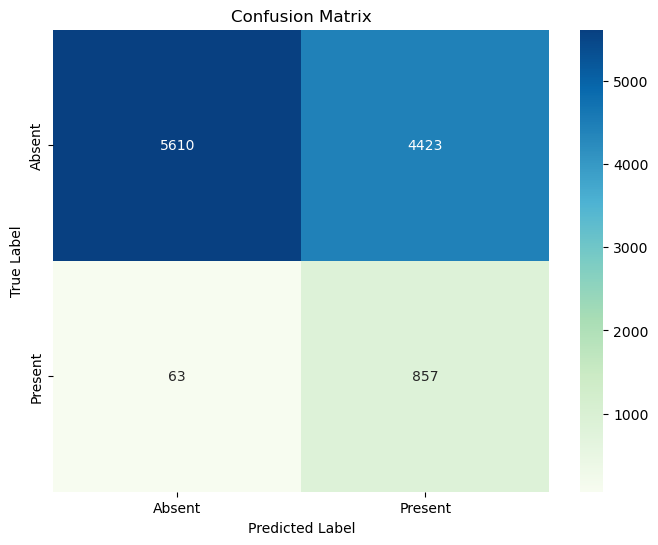

In [8]:
# Scale data
X_test_scaled = scaler.transform(X_test)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.3f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
    
# Create confusion matrix plot
plt.figure(figsize = (8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'GnBu', 
               xticklabels = ['Absent', 'Present'],
               yticklabels = ['Absent', 'Present'])
plt.title('Confusion Matrix')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

*Your answer here*  

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (dead trees)? How would its accuracy compare to your logistic regression model?

*Your answer here*

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy:0.917 

Dummy Confusion Matrix:


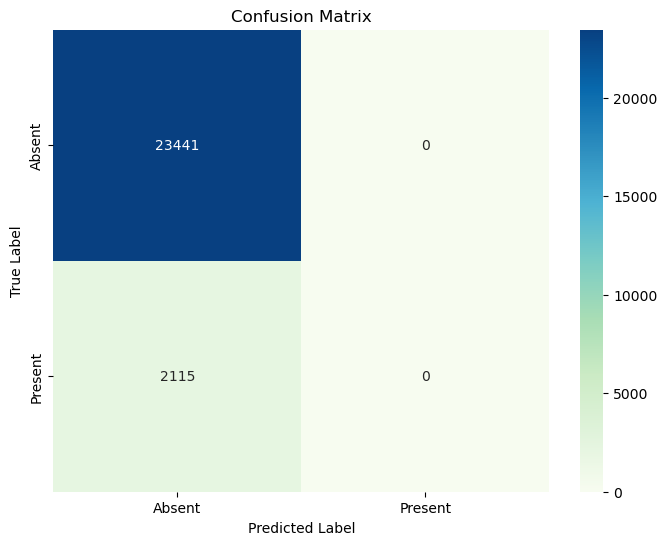

In [9]:
# Make dummy classifier and fit it
dummy = DummyClassifier(strategy = "most_frequent").fit(X_train_scaled, y_train)

# Predict on the training set
dummy_y_train_pred = dummy.predict(X_train_scaled)

# Calculate accuracy on training data
train_accuracy = accuracy_score(y_train, dummy_y_train_pred)

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy:{train_accuracy:.3f} ")
print("\nDummy Confusion Matrix:")

# Create confusion matrix
dummy_cm = confusion_matrix(y_train, dummy_y_train_pred)
    
# Create confusion matrix plot
plt.figure(figsize = (8,6))
sns.heatmap(dummy_cm, annot = True, fmt = 'd', cmap = 'GnBu', 
               xticklabels = ['Absent', 'Present'],
               yticklabels = ['Absent', 'Present'])
plt.title('Confusion Matrix')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [17]:
# Logistic classifier AUC - HELP
log_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]) # Note, do we use x_test_Scaled or just x_test?

print(f"Logistic AUC: {log_auc:.3f}")

Logistic AUC: 0.892


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [19]:
# Dummy classifier AUC - HELP with scaled?
dummy_auc = roc_auc_score(y_test, dummy.predict_proba(X_test_scaled)[:, 1])

print(f"Dummy AUC: {dummy_auc:.3f}")

Dummy AUC: 0.500


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

In [22]:
# Logistic ROC curve
fpr_log, tpr_log, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
auc_log = auc(fpr_log, tpr_log)

# Dummy ROC curve
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, dummy.predict_proba(X_test)[:, 1])
auc_dummy = auc(fpr_dummy, tpr_dummy)

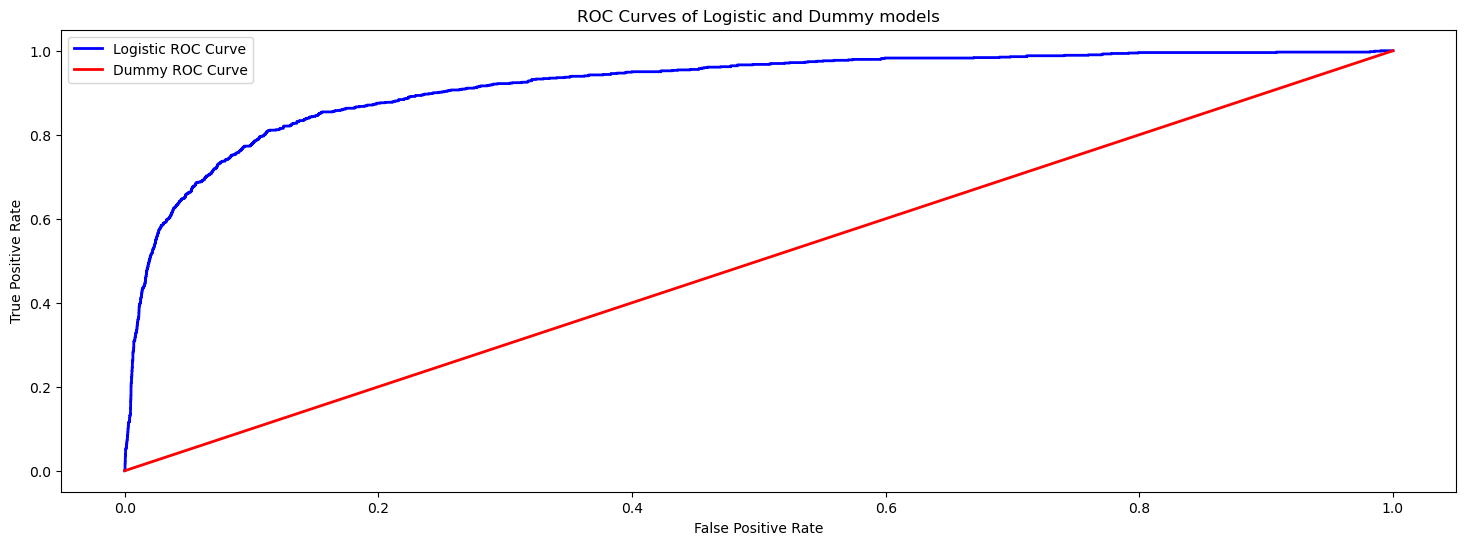

In [31]:
plt.figure(figsize=(18, 6))
plt.plot(fpr_log, tpr_log, label="Logistic ROC Curve", color="blue", lw=2)
plt.plot(fpr_dummy, tpr_dummy, label="Dummy ROC Curve", color="red", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves of Logistic and Dummy models")
plt.legend()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

*Your answer here*

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [37]:
# Extract feature names
feature_names = X_train.columns 

# Get coefficients
coef = model.coef_[0]

# Create df with feature names and coef
importance_df = pd.DataFrame({'Feature' : feature_names, 'Importance' :coef})

# Sort by coef magnitude
importance_df['abs_importance'] = np.abs(importance_df['Importance'])

# Sort values
importance_df = importance_df.sort_values(by='abs_importance', ascending=False)

# Drop the importance column
importance_df = importance_df.drop(columns=['abs_importance'])

# Print the sorted feature importance
print(importance_df)

         Feature  Importance
7        CR_post  -10.503756
1   Times_burned    0.779855
6         CR_pre    0.709967
2        Species    0.201339
3  Genus_species   -0.138533
5           HT_m   -0.115786
0     YrFireName   -0.031289
4         DBH_cm    0.017574


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

*Negative values are features that decrease the likelihood of the predicted outcome. Additionally, the larger the absolute value indicates a stronger influence on the prediction.*